## Este Script de Python se encarga de llevar a cabo el preprocesamiento general de los textos para empezar la implementación del modelo BERT.

Cargando tokenizador para BERT...


Preprocesando para BERT: 100%|██████████| 10/10 [00:00<00:00, 40.38it/s]

Archivo guardado: Datasets_Limpios_Bert/Pregunta_1_CleanText.csv
Archivo guardado: Datasets_Limpios_Bert/Pregunta_2_CleanText.csv
Archivo guardado: Datasets_Limpios_Bert/Pregunta_3_CleanText.csv
Archivo guardado: Datasets_Limpios_Bert/Pregunta_4_CleanText.csv
Archivo guardado: Datasets_Limpios_Bert/Pregunta_5_CleanText.csv
Archivo guardado: Datasets_Limpios_Bert/Pregunta_6_CleanText.csv
Archivo guardado: Datasets_Limpios_Bert/Pregunta_7_CleanText.csv
Archivo guardado: Datasets_Limpios_Bert/Pregunta_8_CleanText.csv
Archivo guardado: Datasets_Limpios_Bert/Pregunta_9_CleanText.csv
Archivo guardado: Datasets_Limpios_Bert/Pregunta_10_CleanText.csv


Gráfica guardada en: Datasets_Limpios_Bert/Distribucion_Longitud_Tokens_bert.png


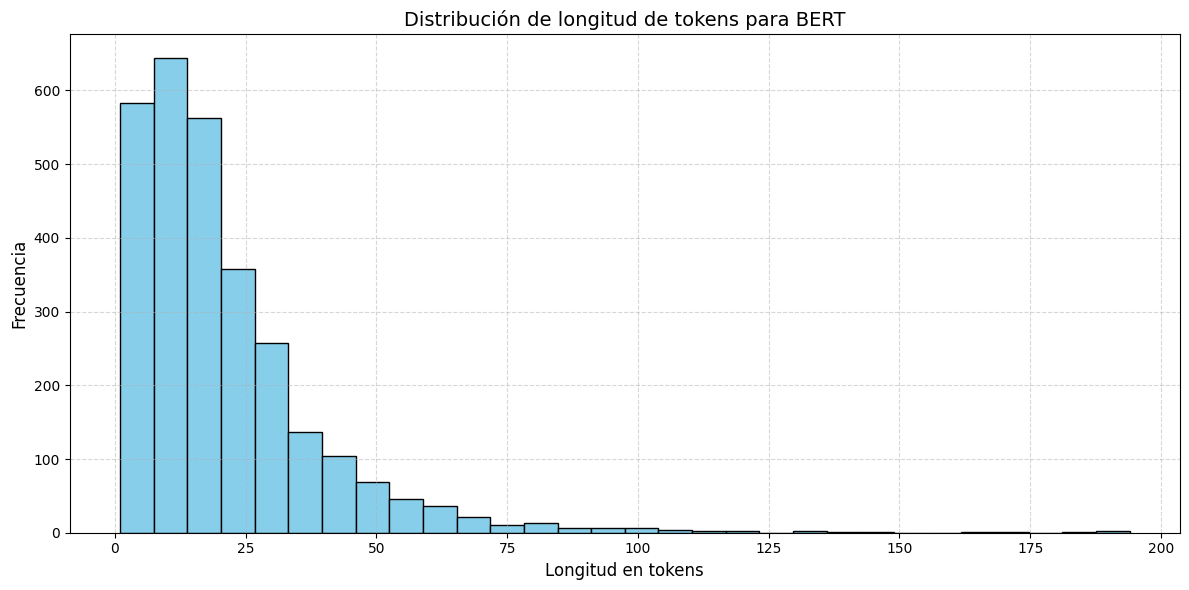

In [13]:
import os
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer

# Diccionario que contiene los nombres de los modelos y sus tokenizadores asociados
modelos_transformer = {
    "bert": "bert-base-multilingual-cased",
    #"bert": "dccuchile/bert-base-spanish-wwm-cased",
    #"bert": "pysentimiento/bert-base-spanish-uncased",
    "roberta": "PlanTL-GOB-ES/roberta-base-bne",
    "robertuito": "pysentimiento/robertuito-base-uncased",
    "distilbert": "distilbert-base-multilingual-cased"
}

# Selección del modelo actual (modificar este valor para cambiar de modelo)
modelo_seleccionado = "bert"
modelo_transformer = modelos_transformer[modelo_seleccionado]

# Cargar el tokenizador correspondiente al modelo seleccionado
print(f"Cargando tokenizador para {modelo_seleccionado.upper()}...")
tokenizer = AutoTokenizer.from_pretrained(modelo_transformer)

# Diccionario de abreviaciones comunes encontradas en textos informales
abreviaciones_comunes = {
    "k": "que", "q": "que", "xq": "porque", "xk": "porque", "pq": "porque",
    "kiero": "quiero", "tmb": "también", "d": "de", "xa": "para", "pa": "para",
    "tb": "también", "x": "por", "bn": "bien", "profe": "profesor",
    "ntp": "no te preocupes", "qndo": "cuando"
}

# Definición de carpetas de entrada y salida para los datasets
input_folder = "../Datasets_Separados_Pregunta"
output_folder = f"Datasets_Limpios_{modelo_seleccionado.title()}"
os.makedirs(output_folder, exist_ok=True)  # Crear la carpeta de salida si no existe

# Función para reemplazar abreviaciones por sus formas completas usando un diccionario

def normalizar_abreviaciones(texto, diccionario):
    if not isinstance(texto, str):
        return ""
    palabras = texto.split()
    palabras_norm = []
    for palabra in palabras:
        # Limpieza de símbolos para asegurar coincidencia con las claves del diccionario
        palabra_limpia = re.sub(r'\W+', '', palabra.lower())
        # Reemplazo por la forma completa si está en el diccionario
        palabra_reemplazada = diccionario.get(palabra_limpia, palabra)
        palabras_norm.append(palabra_reemplazada)
    return ' '.join(palabras_norm)

# Función principal de limpieza compatible con modelos Transformer

def clean_text(text):
    if isinstance(text, str):
        # Paso 1: Normalizar abreviaciones
        text = normalizar_abreviaciones(text, abreviaciones_comunes)
        # Paso 2: Eliminar saltos de línea y múltiples espacios
        text = text.replace('\n', ' ').replace('\r', '')
        text = ' '.join(text.split())  # Compactar espacios múltiples en uno solo
    else:
        text = ""
    return text

# Lista para almacenar la longitud de tokens de todos los textos procesados
todas_las_longitudes = []

# Bucle principal para procesar los archivos CSV del 1 al 10
for i in tqdm(range(1, 11), desc=f"Preprocesando para {modelo_seleccionado.upper()}"):
    # Cargar archivo CSV
    input_file = os.path.join(input_folder, f'Pregunta_{i}.csv')
    df = pd.read_csv(input_file)

    # Eliminar fila duplicada de encabezado si se detecta
    df = df.iloc[1:] if df.columns[0].startswith("Marca_Temporal") else df

    # Renombrar columnas para estandarizar nombres
    df.columns = ['Marca_Temporal', 'ID_Unico', 'Texto']

    # Eliminar registros vacíos en la columna de texto
    df = df.dropna(subset=['Texto'])

    # Aplicar limpieza textual
    df['Texto_Limpio'] = df['Texto'].apply(clean_text)

    # Calcular longitud en tokens usando el tokenizador seleccionado
    df['Longitud_Tokens'] = df['Texto_Limpio'].apply(lambda x: len(tokenizer.tokenize(x)))

    # Agregar longitudes a la lista global
    todas_las_longitudes.extend(df['Longitud_Tokens'].tolist())

    # Guardar DataFrame limpio en un nuevo archivo CSV
    output_file = os.path.join(output_folder, f'Pregunta_{i}_CleanText.csv')
    df.to_csv(output_file, index=False)
    print(f"Archivo guardado: {output_file}")

# Crear histograma de distribución de longitud de tokens
plt.figure(figsize=(12, 6))
plt.hist(todas_las_longitudes, bins=30, color='skyblue', edgecolor='black')
plt.title(f'Distribución de longitud de tokens para {modelo_seleccionado.upper()}', fontsize=14)
plt.xlabel('Longitud en tokens', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Guardar imagen del histograma en alta resolución
grafica_salida = os.path.join(output_folder, f"Distribucion_Longitud_Tokens_{modelo_seleccionado}.png")
plt.savefig(grafica_salida, dpi=300)
print(f"Gráfica guardada en: {grafica_salida}")

## Ahora lo que procede es a cada uno de los datasets, agregar las etiquetas correspondientes a cada uno de los textos.

## Esta parte es esencial para el etiquetado

In [14]:
import os
import pandas as pd
from tqdm import tqdm  # Importar tqdm para la barra de progreso

# Definir rutas de carpetas de entrada y salida
input_folder = "Datasets_Limpios_Bert"
output_folder = "Clasificacion_Manual_Dataset_Etiquetado"

# Asegurar que la carpeta de salida exista, si no, crearla
os.makedirs(output_folder, exist_ok=True)

# Definir las combinaciones de archivos a unir y sus respectivas etiquetas de emoción
combinaciones = {
    "Pregunta_1_6_Felicidad_Etiquetado.csv": ["Pregunta_1_CleanText.csv", "Pregunta_6_CleanText.csv"],
    "Pregunta_2_Tristeza_Etiquetado.csv": ["Pregunta_2_CleanText.csv"],
    "Pregunta_3_9_Estres_Etiquetado.csv": ["Pregunta_3_CleanText.csv", "Pregunta_9_CleanText.csv"],
    "Pregunta_4_5_Preocupacion_Etiquetado.csv": ["Pregunta_4_CleanText.csv", "Pregunta_5_CleanText.csv"],
    "Pregunta_7_10_Miedo_Etiquetado.csv": ["Pregunta_7_CleanText.csv", "Pregunta_10_CleanText.csv"],
    "Pregunta_8_Ira_Etiquetado.csv": ["Pregunta_8_CleanText.csv"]
}

# Diccionario con las emociones asignadas a cada archivo generado
emociones = {
    "Pregunta_1_6_Felicidad_Etiquetado.csv": "Felicidad",
    "Pregunta_2_Tristeza_Etiquetado.csv": "Tristeza",
    "Pregunta_3_9_Estres_Etiquetado.csv": "Estrés",
    "Pregunta_4_5_Preocupacion_Etiquetado.csv": "Preocupación",
    "Pregunta_7_10_Miedo_Etiquetado.csv": "Miedo",
    "Pregunta_8_Ira_Etiquetado.csv": "Ira"
}

# Iterar sobre cada combinación de archivos para procesarlos con barra de progreso
tqdm_bar = tqdm(combinaciones.items(), desc="Procesando archivos", unit="archivo")
for output_file, input_files in tqdm_bar:
    dfs = []  # Lista para almacenar los DataFrames de los archivos a combinar
    for file in input_files:
        file_path = os.path.join(input_folder, file)  # Construir la ruta del archivo
        if os.path.exists(file_path):  # Verificar si el archivo existe
            df = pd.read_csv(file_path, encoding='utf-8')  # Cargar el archivo CSV
            dfs.append(df)  # Agregar el DataFrame a la lista
        else:
            print(f"Advertencia: No se encontró {file_path}")  # Aviso si falta un archivo
    
    # Unir los datasets si hay archivos disponibles
    if dfs:
        merged_df = pd.concat(dfs, ignore_index=True)  # Concatenar los DataFrames en uno solo
        merged_df["Emocion"] = emociones[output_file]  # Agregar la columna de emoción con la etiqueta correspondiente
        
        # Construir la ruta de salida y guardar el archivo procesado
        output_path = os.path.join(output_folder, output_file)
        merged_df.to_csv(output_path, index=False, encoding='utf-8')  # Guardar el archivo CSV
        tqdm_bar.set_postfix({"Guardado": output_file})  # Actualizar barra de progreso con el archivo guardado
    else:
        print(f"No se pudo crear {output_file} debido a archivos faltantes.")  # Mensaje si no hay datos para procesar

tqdm_bar.close()
print("Procesamiento completado.")  # Mensaje final indicando que el proceso ha terminado


Procesando archivos: 100%|██████████| 6/6 [00:00<00:00, 167.60archivo/s, Guardado=Pregunta_8_Ira_Etiquetado.csv]  

Procesamiento completado.


## Una vez que se etiquetaron los datasets con su emoción correspondiente, se tienen que unificar los 6 en un solo dataset general. También, se genera el EDA (Análisis Exploratorio de Datos)

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
Cargando archivos CSV: 100%|██████████| 6/6 [00:00<00:00, 386.72archivo/s]

Dataset unificado guardado en: Clasificacion_Manual_Dataset_Etiquetado/Dataset_Emociones_Completo.csv
       Marca_Temporal  ID_Unico  \
0  4/23/2024 19:48:07  PFNKXS54   
1  4/23/2024 19:48:07  MKZUPRJI   
2  4/23/2024 19:48:07  UJCL56SG   
3  4/23/2024 19:48:07  B2KUCT4P   
4  4/23/2024 19:48:07  GXLRPJ5F   

                                               Texto  \
0  Cuando estoy dando clases, cuando puedo salir ...   
1    Cuando me sale algo bn en la escuela y trabajo    
2    En ver recuerdos, pensar escenarios imaginarios   
3  Cuando paso tiempo con mis amigos, como salir ...   
4  Cuando hago algo y recibo halagos sobre eso, c...   

                                     Texto_Procesado  Longitud_Tokens  \
0  Cuando estoy dando clases, cuando puedo salir ...               84   
1   Cuando me sale algo bien en la escuela y trabajo               10   
2    En ver recuerdos, pensar escenarios imaginarios               12   
3  Cuando paso tiempo con mis amigos, como salir ...      

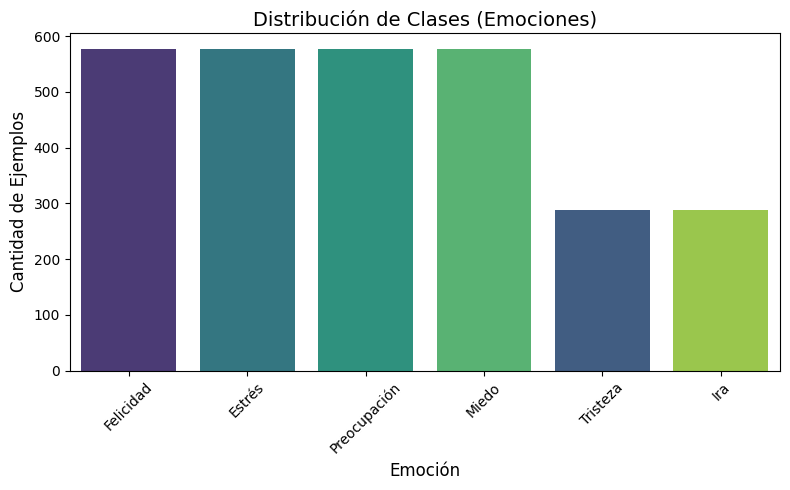

Calculando longitudes: 100%|██████████| 2880/2880 [00:00<00:00, 1451002.46texto/s]


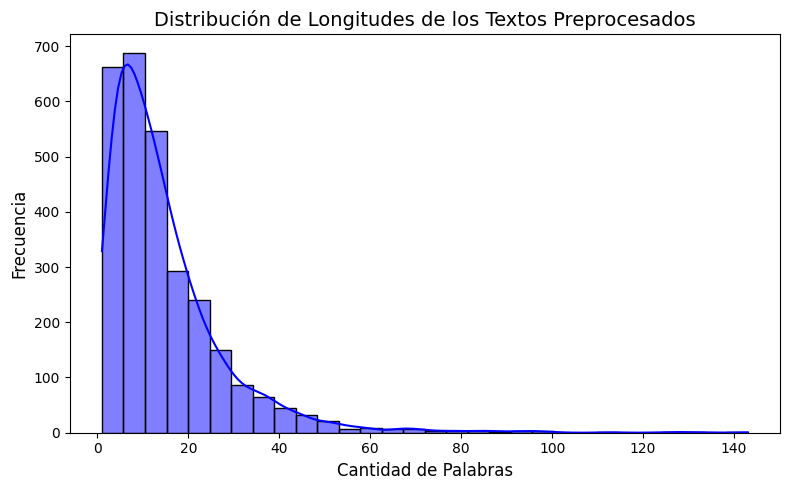

/var/folders/0n/swzcgq212lq4n037_p0h84sr0000gn/T/ipykernel_34900/2206351248.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[w[0] for w in most_common_words], y=[w[1] for w in most_common_words], palette='viridis')


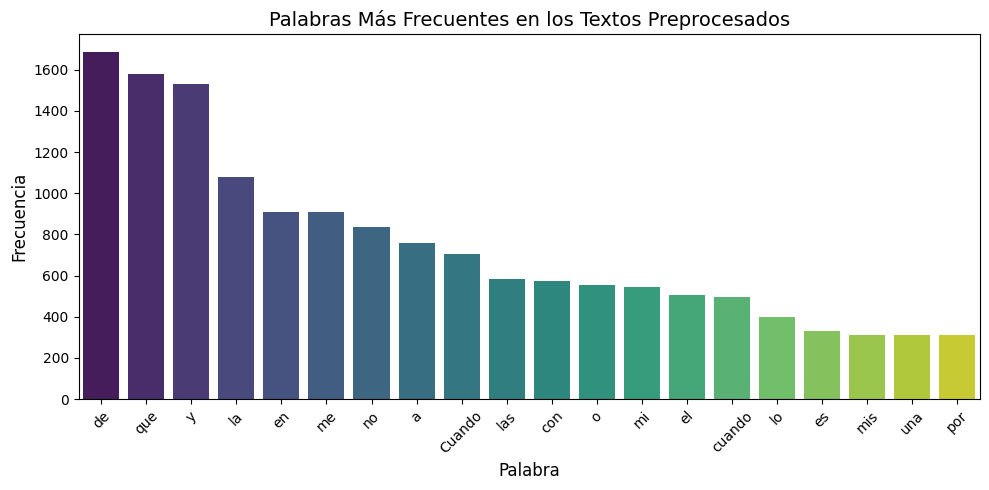


Palabras más comunes:
 [('de', 1687), ('que', 1578), ('y', 1531), ('la', 1081), ('en', 909), ('me', 907), ('no', 837), ('a', 758), ('Cuando', 707), ('las', 583), ('con', 573), ('o', 554), ('mi', 546), ('el', 508), ('cuando', 495), ('lo', 400), ('es', 332), ('mis', 312), ('una', 311), ('por', 311)]


In [15]:
# Este script se encarga de procesar el dataset para obtener un Análisis Exploratorio de Datos (EDA)
#Este script es importante para conocer el dataset antes de preprocesar y construir el modelo
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from tqdm import tqdm
from sklearn.utils import resample

# Descargar el recurso necesario para tokenización de palabras
nltk.download('punkt')

# Definición de carpeta de entrada y nombre del archivo final unificado
input_folder = "Clasificacion_Manual_Dataset_Etiquetado"
output_file = os.path.join(input_folder, "Dataset_Emociones_Completo.csv")

# Lista con los nombres de archivos CSV en el orden deseado de emociones
orden_emociones = [
    "Pregunta_1_6_Felicidad_Etiquetado.csv",
    "Pregunta_2_Tristeza_Etiquetado.csv",
    "Pregunta_3_9_Estres_Etiquetado.csv",
    "Pregunta_4_5_Preocupacion_Etiquetado.csv",
    "Pregunta_7_10_Miedo_Etiquetado.csv",
    "Pregunta_8_Ira_Etiquetado.csv"
]

# Filtrar y cargar solo los archivos existentes desde la carpeta
csv_files = [f for f in orden_emociones if f in os.listdir(input_folder)]
dfs = []

# Iterar sobre cada archivo CSV y cargar los datos con barra de progreso
for file in tqdm(csv_files, desc="Cargando archivos CSV", unit="archivo"):
    file_path = os.path.join(input_folder, file)
    df = pd.read_csv(file_path, encoding='utf-8')

    # Renombrar columna si se encuentra 'Texto_Limpio' en lugar de 'Texto_Procesado'
    if 'Texto_Limpio' in df.columns:
        df.rename(columns={'Texto_Limpio': 'Texto_Procesado'}, inplace=True)

    dfs.append(df)

# Concatenar todos los DataFrames en uno solo y guardar archivo final
if dfs:
    df_complete = pd.concat(dfs, ignore_index=True)
    df_complete.to_csv(output_file, index=False, encoding='utf-8')
    print(f"Dataset unificado guardado en: {output_file}")
else:
    raise FileNotFoundError("No se encontraron archivos válidos en la carpeta especificada.")

# Leer el dataset unificado desde el archivo CSV
df = pd.read_csv(output_file, encoding='utf-8')

# Mostrar primeras filas para revisión visual y estructura del DataFrame
print(df.head())
df.info()

# Mostrar conteo de valores nulos por columna
print("\nValores nulos en el dataset:\n", df.isnull().sum())

# Mostrar cantidad de ejemplos por clase emocional
print("\nCantidad de ejemplos por clase:")
print(df['Emocion'].value_counts())

# Visualizar la distribución de clases emocionales en el dataset
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Emocion', order=df['Emocion'].value_counts().index,
              hue='Emocion', palette='viridis', legend=False)
plt.title("Distribución de Clases (Emociones)", fontsize=14)
plt.xlabel("Emoción", fontsize=12)
plt.ylabel("Cantidad de Ejemplos", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(input_folder, "Distribucion_Clases_Emociones.png"), dpi=300)
plt.show()

# Determinar la columna que contiene los textos preprocesados
columna_texto = 'Texto_Procesado' if 'Texto_Procesado' in df.columns else None

# Si la columna existe, calcular longitud del texto en palabras por fila
if columna_texto:
    df['Longitud_Texto'] = [len(str(x).split()) for x in tqdm(df[columna_texto], desc="Calculando longitudes", unit="texto")]
else:
    raise KeyError("No se encontró una columna válida con texto procesado. Asegúrese de tener 'Texto_Procesado' o 'Texto_Limpio'.")

# Graficar histograma de la longitud de los textos (número de palabras)
plt.figure(figsize=(8, 5))
sns.histplot(df['Longitud_Texto'], bins=30, kde=True, color='blue')
plt.title("Distribución de Longitudes de los Textos Preprocesados", fontsize=14)
plt.xlabel("Cantidad de Palabras", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(input_folder, "Distribucion_Longitudes_Texto.png"), dpi=300)
plt.show()

# Concatenar todos los textos para contar palabras más frecuentes
todos_los_textos = ' '.join(df[columna_texto].dropna())
all_words = todos_los_textos.split()
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)

# Graficar las palabras más frecuentes en el corpus preprocesado
plt.figure(figsize=(10, 5))
sns.barplot(x=[w[0] for w in most_common_words], y=[w[1] for w in most_common_words], palette='viridis')
plt.title("Palabras Más Frecuentes en los Textos Preprocesados", fontsize=14)
plt.xlabel("Palabra", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(input_folder, "Palabras_Mas_Frecuentes.png"), dpi=300)
plt.show()

# Mostrar las palabras más frecuentes en consola
print("\nPalabras más comunes:\n", most_common_words)


In [8]:
#Si se realiza balanceo de clase, este script es el correspondiente para generar un nuevo dataset balanceado.

# ==========================
# BALANCEO DE CLASES (Oversampling)
# ==========================

# Separar clases minoritarias
df_mayor = df[df['Emocion'].isin(['Felicidad', 'Estrés', 'Preocupación', 'Miedo'])]
df_tristeza = df[df['Emocion'] == 'Tristeza']
df_ira = df[df['Emocion'] == 'Ira']

# Replicar clases minoritarias hasta 576 instancias
tristeza_upsampled = resample(df_tristeza, replace=True, n_samples=576, random_state=42)
ira_upsampled = resample(df_ira, replace=True, n_samples=576, random_state=42)

# Concatenar dataset balanceado
df_balanceado = pd.concat([df_mayor, tristeza_upsampled, ira_upsampled])
df_balanceado = df_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

# Guardar nuevo dataset balanceado
output_balanceado = os.path.join(input_folder, "Dataset_Emociones_Balanceado.csv")
df_balanceado.to_csv(output_balanceado, index=False)
print("\nDataset balanceado guardado en:", output_balanceado)
print("\nDistribución del dataset balanceado:")
print(df_balanceado['Emocion'].value_counts())


Dataset balanceado guardado en: Clasificacion_Manual_Dataset_Etiquetado/Dataset_Emociones_Balanceado.csv

Distribución del dataset balanceado:
Emocion
Miedo           576
Felicidad       576
Tristeza        576
Estrés          576
Ira             576
Preocupación    576
Name: count, dtype: int64
